# Vehicle detection

In [1]:
from sklearn import svm, grid_search
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import cv2
from skimage.feature import hog
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import pickle
from sklearn.externals import joblib 
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Process the data

In [2]:
## read in the data
with_car_files = glob.glob('train_data/vehicles/GTI_Far/*.png') + glob.glob('train_data/vehicles/GTI_Left/*.png') + \
                glob.glob('train_data/vehicles/GTI_MiddleClose/*.png') + glob.glob('train_data/vehicles/GTI_Right/*.png') \
                + glob.glob('train_data/vehicles/KITTI_extracted/*.png')
non_car_files = glob.glob('train_data/non-vehicles/Extras/*.png') + glob.glob('train_data/non-vehicles/GTI/*.png')

with_car_pics = []
non_car_pics = []
for file in with_car_files:
    image = mpimg.imread(file)
    with_car_pics.append(image)
for file in non_car_files:
    image = mpimg.imread(file)
    non_car_pics.append(image)
    
print('Together %d images with car and %d images without car' %(len(with_car_pics), len(non_car_pics)))

Together 8792 images with car and 8968 images without car


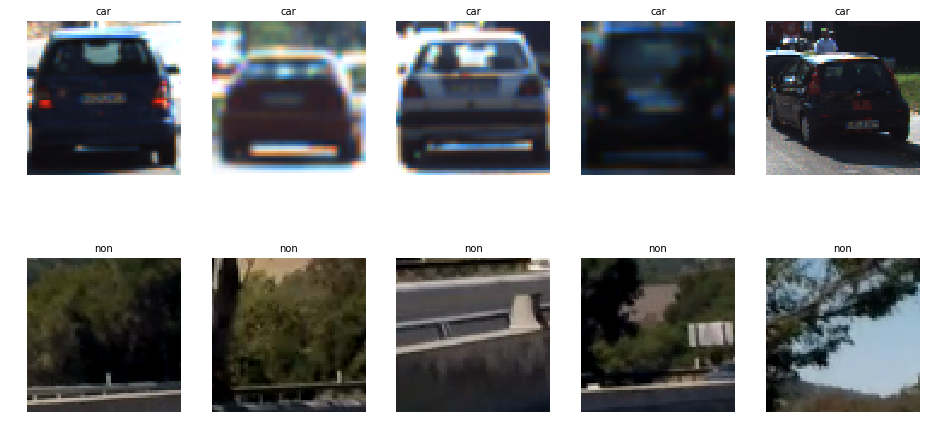

In [19]:
## show some of the pictures
plt.figure(figsize=(16,8))
for i in range(5):
    plt.subplot(2,5,i+1).axis('off')
    plt.subplot(2,5,i+1).set_title('car', fontsize=10)
    plt.imshow(with_car_pics[4000 + 100 * i])
    plt.subplot(2,5,i+6).axis('off')
    plt.subplot(2,5,i+6).set_title('non', fontsize=10)
    plt.imshow(non_car_pics[4000 + 100 * i])

In [25]:
## show the data size
print('data size is:', non_car_pics[0].shape)

data size is: (64, 64, 3)


In [2]:
## define a function to find hog features of the images
## set vis as true to show the result.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=True):
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

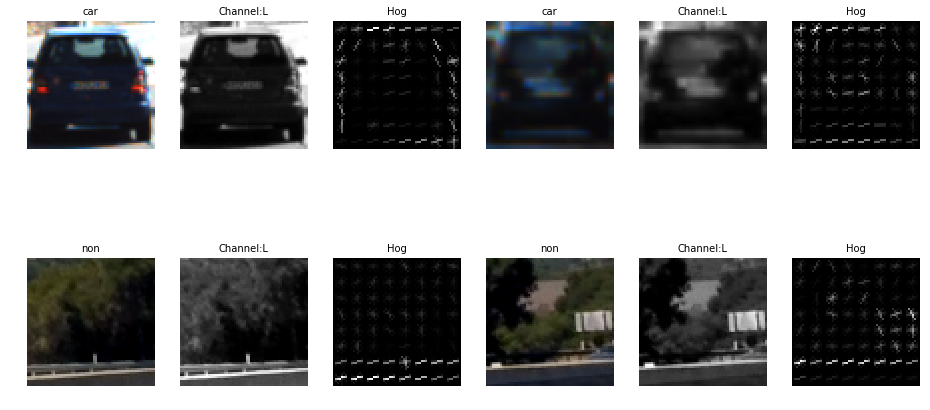

In [63]:
## visualize the result of Hog on the image in L channels
cell_per_block_set = 2
channel = 1

plt.figure(figsize=(16,8))
for i in (0, 3):
    channel_name = ('H', 'L', 'S')
    
    plt.subplot(2,6,i+1).axis('off')
    plt.subplot(2,6,i+1).set_title('car', fontsize=10)
    plt.imshow(with_car_pics[4000 + 100 * i])
    
    plt.subplot(2,6,i+2).axis('off')
    plt.subplot(2,6,i+2).set_title('Channel:' + channel_name[channel], fontsize=10)  
    img_channel = cv2.cvtColor(with_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    plt.imshow(img_channel, cmap = 'gray')
    
    plt.subplot(2,6,i+3).axis('off')
    plt.subplot(2,6,i+3).set_title('Hog', fontsize=10)
    _, ret = get_hog_features(img_channel, orient = 9, pix_per_cell= 8, cell_per_block= cell_per_block_set, vis = True)
    plt.imshow(ret, cmap = 'gray')
    
    plt.subplot(2,6,i+7).axis('off')
    plt.subplot(2,6,i+7).set_title('non', fontsize=10)
    plt.imshow(non_car_pics[4000 + 100 * i])
    
    
    plt.subplot(2,6,i+8).axis('off')
    plt.subplot(2,6,i+8).set_title('Channel:' + channel_name[channel], fontsize=10)  
    img_channel = cv2.cvtColor(non_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    plt.imshow(img_channel, cmap = 'gray')    
    
    plt.subplot(2,6,i+9).axis('off')
    plt.subplot(2,6,i+9).set_title('Hog', fontsize=10)
    img_channel = cv2.cvtColor(non_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    _, ret = get_hog_features(img_channel, orient = 9, pix_per_cell= 8, cell_per_block= cell_per_block_set, vis = True)
    plt.imshow(ret, cmap = 'gray')

In [3]:
## combine the features in color space

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
## combine the features in hog, spatial and in color histogramm

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            string = 'cv2.COLOR_RGB2' + color_space
            feature_image = cv2.cvtColor(image, eval(string))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
## generate the labels for datas
Y = []
for i in with_car_pics:
    Y.append(1)
for i in non_car_pics:
    Y.append(0)
print('Finish!')

Finish!


In [7]:
## set parameters
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

feature_with = extract_features(with_car_pics, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)
feature_non = extract_features(non_car_pics, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

# feature_with = extract_features(with_car_pics, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=False, 
#                         hist_feat=False, hog_feat=True)
# feature_non = extract_features(non_car_pics, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=False, 
#                         hist_feat=False, hog_feat=True)

# hogspatial_non = extract_features(with_car_pics, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=True, 
#                         hist_feat=False, hog_feat=True)
# hogspatial_with = extract_features(non_car_pics, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=True, 
#                         hist_feat=False, hog_feat=True)

print('Finish extract the features!')

## split the data into validation(20%) and training set,also shuffle the data. 
X = feature_with + feature_non

rand_state = random.randint(0,99)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=rand_state)

print('Finish!')

Finish extract the features!
Finish!


In [8]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler
scaled_train_X = X_scaler.transform(X_train)

print('Finish!')

Finish!


In [19]:
## save the scaler
data_dict = {'X_scaler': X_scaler}
with open('data.pickle','wb') as file:
    pickle.dump(data_dict, file)

In [10]:
## visualize the data

## 2. Train the svm classifier

In [9]:
## turn the parameters with hog features
print('start tuning the parameters......')
parameters = {'C': [1, 2, 3]}
tune_step = {'C': 1}
svr = svm.LinearSVC()
old_score = 0.
j = 1
scaled_test_X = X_scaler.transform(X_test)
while True:
    print('epoch', j, ', start at:', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    j = j + 1
    clf = grid_search.GridSearchCV(svr, parameters, n_jobs = 3)
    clf.fit(scaled_train_X, y_train)
    new_score = clf.best_estimator_.score(scaled_test_X,y_test)
    print('Parameters: ', clf.best_params_)
    print('Score: ', new_score)
    if new_score-old_score >= 0.01 or new_score < 0.99 or j < 30:
        old_score = new_score
        for i in parameters:
            if clf.best_params_[i] == parameters[i][1]:
                tune_step[i] = tune_step[i]/2
                parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
            elif clf.best_params_[i] == parameters[i][0]:
                parameters[i] = [clf.best_params_[i]/2, clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
            else:
                parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
    else:
        break
        
print('tuning finished!')

start tuning the parameters......
epoch 1 , start at: 2018-05-17 20:17:17
Parameters:  {'C': 1}
Score:  0.931306306306
epoch 2 , start at: 2018-05-17 20:18:06
Parameters:  {'C': 1}
Score:  0.935810810811
epoch 3 , start at: 2018-05-17 20:18:56
Parameters:  {'C': 0.5}
Score:  0.933558558559
epoch 4 , start at: 2018-05-17 20:19:45
Parameters:  {'C': 0.25}
Score:  0.9375
epoch 5 , start at: 2018-05-17 20:20:32
Parameters:  {'C': 0.125}
Score:  0.936936936937
epoch 6 , start at: 2018-05-17 20:21:17
Parameters:  {'C': 0.0625}
Score:  0.938344594595
epoch 7 , start at: 2018-05-17 20:22:00
Parameters:  {'C': 0.03125}
Score:  0.938907657658
epoch 8 , start at: 2018-05-17 20:22:42
Parameters:  {'C': 0.015625}
Score:  0.940878378378
epoch 9 , start at: 2018-05-17 20:23:24
Parameters:  {'C': 0.0078125}
Score:  0.942849099099
epoch 10 , start at: 2018-05-17 20:24:06
Parameters:  {'C': 0.00390625}
Score:  0.943412162162
epoch 11 , start at: 2018-05-17 20:24:38
Parameters:  {'C': 0.001953125}
Score:

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...erm1\\lib\\site-packages\\ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\runpy.py in _run_code(code=<code object <module> at 0x0000024C11044660, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\s...ges\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...erm1\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...m1\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...erm1\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000024C11044660, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\s...ges\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...erm1\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...m1\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    340             raise RuntimeError('Event loop is running.')
    341         self._set_coroutine_wrapper(self._debug)
    342         self._thread_id = threading.get_ident()
    343         try:
    344             while True:
--> 345                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    346                 if self._stopping:
    347                     break
    348         finally:
    349             self._stopping = False

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1307                         logger.warning('Executing %s took %.3f seconds',
   1308                                        _format_handle(handle), dt)
   1309                 finally:
   1310                     self._current_handle = None
   1311             else:
-> 1312                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(900, 1)>>
   1313         handle = None  # Needed to break cycles when an exception occurs.
   1314 
   1315     def _set_coroutine_wrapper(self, enabled):
   1316         try:

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(900, 1)>)
    120             self._callback = None
    121             self._args = None
    122 
    123     def _run(self):
    124         try:
--> 125             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (900, 1)
    126         except Exception as exc:
    127             cb = _format_callback_source(self._callback, self._args)
    128             msg = 'Exception in callback {}'.format(cb)
    129             context = {

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=900, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 17, 18, 17, 17, 417000, tzinfo=tzutc()), 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'session': '1fe42f97fd7243b1b88b5011139ab736', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1fe42f97fd7243b1b88b5011139ab736']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 17, 18, 17, 17, 417000, tzinfo=tzutc()), 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'session': '1fe42f97fd7243b1b88b5011139ab736', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1fe42f97fd7243b1b88b5011139ab736'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 17, 18, 17, 17, 417000, tzinfo=tzutc()), 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'session': '1fe42f97fd7243b1b88b5011139ab736', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f95dc315a3734671b2e7e83e90acdc75', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.While object>, <_ast.Expr object>], cell_name='<ipython-input-9-2abbf7aa3560>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 24c190eae10, executio...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000024C4ACCF030, file "<ipython-input-9-2abbf7aa3560>", line 9>
        result = <ExecutionResult object at 24c190eae10, executio...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000024C4ACCF030, file "<ipython-input-9-2abbf7aa3560>", line 9>, result=<ExecutionResult object at 24c190eae10, executio...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000024C4ACCF030, file "<ipython-input-9-2abbf7aa3560>", line 9>
        self.user_global_ns = {'In': ['', 'from sklearn import svm, grid_search\nimport time...port train_test_split\nimport random\nimport pickle', "## read in the data\nwith_car_files = glob.glob('...ut car' %(len(with_car_pics), len(non_car_pics)))", '## define a function to find hog features of the..., hog_image\n    else:\n        return hog_features', '## combine the features in color space\n\n# Define...nters and feature vector\n    return hist_features', '## combine the features in hog, spatial and in c...eturn list of feature vectors\n    return features', "## generate the labels for datas\nY = []\nfor i in...in non_car_pics:\n    Y.append(0)\nprint('Finish!')", "## set parameters\ncolor_space = 'HLS' # Can be R...e=0.2, random_state=rand_state)\n\nprint('Finish!')", "# Fit a per-column scaler\nX_scaler = StandardSca...X = X_scaler.transform(X_train)\n\nprint('Finish!')", "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')"], 'Out': {}, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X': [array([  1.49750000e+02,   6.33333325e-01,   5.8...0686747e-03,   2.76230673e+00,   2.13254685e+01]), array([  1.52613647e+02,   6.33333325e-01,   5.8...1318939e-03,   2.69556751e+00,   1.49673079e+01]), array([  9.86703339e+01,   5.52941203e-01,   6.1...9347674e-02,   6.83875150e+00,   3.46312340e+01]), array([  1.72578674e+02,   3.66666675e-01,   6.4...6944567e-03,   4.96864443e+00,   1.42235876e+01]), array([  1.61090500e+02,   3.97058845e-01,   7.4...3615838e-02,   3.39686129e+00,   1.59827142e+01]), array([  1.74714294e+02,   3.66176486e-01,   7.6...1330339e-02,   2.72327939e+01,   3.84446042e+01]), array([  1.50833328e+02,   3.73039216e-01,   4.3...4313154e-02,   2.81400452e+00,   3.73254863e+00]), array([  1.73942307e+02,   3.79411787e-01,   6.4...5651999e-02,   2.29349446e+01,   3.15685225e+01]), array([  1.60500000e+02,   3.49999994e-01,   3.0...3389607e-02,   4.97127499e+00,   1.55751887e+01]), array([  1.72000000e+02,   3.48039240e-01,   3.3...4910570e-03,   8.94240136e+00,   1.52371766e+01]), array([  1.79944855e+02,   2.43627459e-01,   1.3...7710252e-02,   8.22989412e+00,   1.35617093e+01]), array([  1.88980469e+02,   3.14215720e-01,   1.6...4290324e-02,   1.09303309e+01,   1.52545650e+01]), array([  1.80000000e+02,   2.67647088e-01,   9.9...8050551e-02,   4.20450917e+00,   1.94075630e+01]), array([  2.08972443e+02,   3.10294151e-01,   1.2...3169142e-03,   4.74231580e+00,   9.61249933e-02]), array([  1.87350006e+02,   2.32352957e-01,   2.0...4101518e-01,   8.74839210e+00,   2.48119675e+01]), array([  1.79007355e+02,   3.12745094e-01,   1.0...5987864e-02,   9.64233752e+00,   2.57384062e+01]), array([  1.81622803e+02,   2.60294139e-01,   1.3...0894239e-02,   3.75497039e+00,   1.90996590e+00]), array([  1.90214294e+02,   2.87254930e-01,   1.3...3175269e-02,   3.41866402e+00,   2.85418749e+00]), array([  1.96071426e+02,   3.20588231e-01,   4.5...4455745e-02,   4.42350713e+00,   8.92472710e+00]), array([  1.92045456e+02,   4.41666663e-01,   5.0...6993043e-02,   0.00000000e+00,   2.67952449e+01]), ...], 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'X_test': [array([  3.89285736e+01,   1.71568617e-02,   8.4...0853976e-03,   1.77420162e-01,   1.30825641e+00]), array([  5.14188309e+01,   6.07843176e-02,   7.3...8644999e-01,   9.03202155e+00,   2.03474666e+00]), array([  9.37500000e+01,   1.80392161e-01,   8.7...4136765e-02,   2.20042989e+00,   1.57839414e+01]), array([  3.45000000e+01,   4.95098047e-02,   1.8...8077910e-03,   1.99260773e+00,   1.89243557e+00]), array([  0.00000000e+00,   1.00000000e+00,   0.0...1376015e-03,   1.43451674e-01,   9.77245633e-01]), array([  6.22727280e+01,   1.51470602e-01,   3.3...6589173e-03,   4.12334565e+00,   3.13348631e+00]), array([  2.06875000e+02,   7.56862760e-01,   3.8...2863381e-01,   6.73511882e+00,   3.47421504e+00]), array([  2.34500000e+02,   8.18627477e-02,   1.9...4233463e-05,   0.00000000e+00,   1.39519199e+01]), array([  1.62000000e+02,   2.90196091e-01,   6.7...1196992e-02,   1.13432292e+01,   5.16269245e+01]), array([  1.25194809e+02,   7.53431380e-01,   7.3...1381559e-04,   7.06881750e-01,   3.01727820e+00]), array([  5.07500000e+01,   1.48529410e-01,   5.6...0728203e-03,   8.95380213e-02,   1.30288703e+00]), array([  1.73221161e+02,   2.42156863e-01,   9.1...8190665e-02,   2.17747956e+00,   5.95873200e+00]), array([  2.92105255e+01,   3.87254894e-01,   9.8...1378724e-03,   2.56912678e-01,   1.49351726e+00]), array([  1.92970676e+01,   6.07843161e-01,   4.0...8483884e-03,   2.12155855e-01,   1.21219934e+00]), array([  1.72613632e+02,   4.91666704e-01,   3.9...2241575e-04,   1.01671374e-01,   1.81237382e+00]), array([  1.84226196e+02,   1.76960796e-01,   9.1...4189742e-02,   3.92629351e+00,   3.73485808e+00]), array([  2.27291641e+02,   2.62254894e-01,   6.1...9745298e-04,   0.00000000e+00,   0.00000000e+00]), array([  6.75402832e+01,   3.85294110e-01,   9.7...3488907e-03,   2.02854938e+00,   1.73104628e+00]), array([  1.23500000e+02,   1.92156866e-01,   5.7...2880081e-02,   4.78403846e+00,   5.02654736e+00]), array([  2.53750000e+02,   1.22549031e-02,   5.9...4175665e-03,   4.93945965e+00,   2.24415853e+00]), ...], 'X_train': [array([  1.87500000e+02,   5.86274505e-01,   7.5...1258160e-02,   1.26022880e+01,   6.88497110e+01]), array([  3.23375000e+02,   1.06372550e-01,   1.1...0987402e-03,   8.40732418e-01,   3.46947863e+00]), array([  7.50000000e+01,   5.44117689e-02,   6.3...4634125e-03,   4.39892498e+00,   1.66614353e+00]), array([  1.36208328e+02,   2.28431374e-01,   7.7...7722807e-02,   5.73762308e+00,   8.13735173e+00]), array([  1.86250000e+02,   4.55882363e-02,   1.1...1465456e-03,   9.79527776e-01,   3.77649060e+00]), array([  1.06818176e+02,   2.40196094e-01,   8.3...4187507e-03,   8.03457366e-01,   2.26883578e+00]), array([  1.20178566e+02,   7.60784328e-01,   7.7...7402151e-03,   1.48486364e-01,   4.04405384e-01]), array([  2.40000000e+02,   1.57352954e-01,   5.2...0000000e+00,   2.18248827e-02,   3.94211052e-02]), array([  9.83997726e+01,   3.20098042e-01,   2.3...2465127e-03,   2.22776108e+01,   1.64097579e+01]), array([  9.45220566e+01,   2.91176468e-01,   1.1...2505907e-02,   3.98553090e+00,   3.63342596e+01]), array([  1.20178574e+02,   5.60784340e-01,   5.8...5927553e-02,   2.12666193e-01,   8.65932757e+00]), array([  1.10982147e+02,   2.14215696e-01,   1.9...9802897e-02,   2.18170151e-01,   3.13871116e+00]), array([  9.17708359e+01,   3.69117647e-01,   8.6...0000000e+00,   1.54789944e+01,   3.20637954e+01]), array([  5.70741272e+01,   2.88725495e-01,   1.6...9395041e-03,   1.47571136e+00,   2.76777991e+00]), array([  2.20093750e+02,   1.71078444e-01,   2.5...4467272e-02,   6.57575374e+00,   2.38852423e+00]), array([  6.58258820e+01,   1.42647058e-01,   2.8...4394427e-04,   7.96396097e+00,   2.88289393e+00]), array([  1.42000000e+02,   2.94117659e-01,   3.6...2349289e-02,   1.48598039e+00,   1.03062385e+00]), array([  2.07891891e+02,   6.52450979e-01,   4.2...6323344e-02,   1.58677039e+01,   5.99390965e+00]), array([  5.70000000e+01,   9.39705849e-01,   8.1...0725787e-03,   1.16043411e+00,   1.67057471e+00]), array([  1.40380951e+02,   3.45098048e-01,   8.8...5332197e-02,   5.23877420e+00,   1.38030355e+01]), ...], 'Y': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...], '_': '', '__': '', ...}
        self.user_ns = {'In': ['', 'from sklearn import svm, grid_search\nimport time...port train_test_split\nimport random\nimport pickle', "## read in the data\nwith_car_files = glob.glob('...ut car' %(len(with_car_pics), len(non_car_pics)))", '## define a function to find hog features of the..., hog_image\n    else:\n        return hog_features', '## combine the features in color space\n\n# Define...nters and feature vector\n    return hist_features', '## combine the features in hog, spatial and in c...eturn list of feature vectors\n    return features', "## generate the labels for datas\nY = []\nfor i in...in non_car_pics:\n    Y.append(0)\nprint('Finish!')", "## set parameters\ncolor_space = 'HLS' # Can be R...e=0.2, random_state=rand_state)\n\nprint('Finish!')", "# Fit a per-column scaler\nX_scaler = StandardSca...X = X_scaler.transform(X_train)\n\nprint('Finish!')", "## turn the parameters with hog features\nprint('...\n        break\n        \nprint('tuning finished!')"], 'Out': {}, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X': [array([  1.49750000e+02,   6.33333325e-01,   5.8...0686747e-03,   2.76230673e+00,   2.13254685e+01]), array([  1.52613647e+02,   6.33333325e-01,   5.8...1318939e-03,   2.69556751e+00,   1.49673079e+01]), array([  9.86703339e+01,   5.52941203e-01,   6.1...9347674e-02,   6.83875150e+00,   3.46312340e+01]), array([  1.72578674e+02,   3.66666675e-01,   6.4...6944567e-03,   4.96864443e+00,   1.42235876e+01]), array([  1.61090500e+02,   3.97058845e-01,   7.4...3615838e-02,   3.39686129e+00,   1.59827142e+01]), array([  1.74714294e+02,   3.66176486e-01,   7.6...1330339e-02,   2.72327939e+01,   3.84446042e+01]), array([  1.50833328e+02,   3.73039216e-01,   4.3...4313154e-02,   2.81400452e+00,   3.73254863e+00]), array([  1.73942307e+02,   3.79411787e-01,   6.4...5651999e-02,   2.29349446e+01,   3.15685225e+01]), array([  1.60500000e+02,   3.49999994e-01,   3.0...3389607e-02,   4.97127499e+00,   1.55751887e+01]), array([  1.72000000e+02,   3.48039240e-01,   3.3...4910570e-03,   8.94240136e+00,   1.52371766e+01]), array([  1.79944855e+02,   2.43627459e-01,   1.3...7710252e-02,   8.22989412e+00,   1.35617093e+01]), array([  1.88980469e+02,   3.14215720e-01,   1.6...4290324e-02,   1.09303309e+01,   1.52545650e+01]), array([  1.80000000e+02,   2.67647088e-01,   9.9...8050551e-02,   4.20450917e+00,   1.94075630e+01]), array([  2.08972443e+02,   3.10294151e-01,   1.2...3169142e-03,   4.74231580e+00,   9.61249933e-02]), array([  1.87350006e+02,   2.32352957e-01,   2.0...4101518e-01,   8.74839210e+00,   2.48119675e+01]), array([  1.79007355e+02,   3.12745094e-01,   1.0...5987864e-02,   9.64233752e+00,   2.57384062e+01]), array([  1.81622803e+02,   2.60294139e-01,   1.3...0894239e-02,   3.75497039e+00,   1.90996590e+00]), array([  1.90214294e+02,   2.87254930e-01,   1.3...3175269e-02,   3.41866402e+00,   2.85418749e+00]), array([  1.96071426e+02,   3.20588231e-01,   4.5...4455745e-02,   4.42350713e+00,   8.92472710e+00]), array([  1.92045456e+02,   4.41666663e-01,   5.0...6993043e-02,   0.00000000e+00,   2.67952449e+01]), ...], 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'X_test': [array([  3.89285736e+01,   1.71568617e-02,   8.4...0853976e-03,   1.77420162e-01,   1.30825641e+00]), array([  5.14188309e+01,   6.07843176e-02,   7.3...8644999e-01,   9.03202155e+00,   2.03474666e+00]), array([  9.37500000e+01,   1.80392161e-01,   8.7...4136765e-02,   2.20042989e+00,   1.57839414e+01]), array([  3.45000000e+01,   4.95098047e-02,   1.8...8077910e-03,   1.99260773e+00,   1.89243557e+00]), array([  0.00000000e+00,   1.00000000e+00,   0.0...1376015e-03,   1.43451674e-01,   9.77245633e-01]), array([  6.22727280e+01,   1.51470602e-01,   3.3...6589173e-03,   4.12334565e+00,   3.13348631e+00]), array([  2.06875000e+02,   7.56862760e-01,   3.8...2863381e-01,   6.73511882e+00,   3.47421504e+00]), array([  2.34500000e+02,   8.18627477e-02,   1.9...4233463e-05,   0.00000000e+00,   1.39519199e+01]), array([  1.62000000e+02,   2.90196091e-01,   6.7...1196992e-02,   1.13432292e+01,   5.16269245e+01]), array([  1.25194809e+02,   7.53431380e-01,   7.3...1381559e-04,   7.06881750e-01,   3.01727820e+00]), array([  5.07500000e+01,   1.48529410e-01,   5.6...0728203e-03,   8.95380213e-02,   1.30288703e+00]), array([  1.73221161e+02,   2.42156863e-01,   9.1...8190665e-02,   2.17747956e+00,   5.95873200e+00]), array([  2.92105255e+01,   3.87254894e-01,   9.8...1378724e-03,   2.56912678e-01,   1.49351726e+00]), array([  1.92970676e+01,   6.07843161e-01,   4.0...8483884e-03,   2.12155855e-01,   1.21219934e+00]), array([  1.72613632e+02,   4.91666704e-01,   3.9...2241575e-04,   1.01671374e-01,   1.81237382e+00]), array([  1.84226196e+02,   1.76960796e-01,   9.1...4189742e-02,   3.92629351e+00,   3.73485808e+00]), array([  2.27291641e+02,   2.62254894e-01,   6.1...9745298e-04,   0.00000000e+00,   0.00000000e+00]), array([  6.75402832e+01,   3.85294110e-01,   9.7...3488907e-03,   2.02854938e+00,   1.73104628e+00]), array([  1.23500000e+02,   1.92156866e-01,   5.7...2880081e-02,   4.78403846e+00,   5.02654736e+00]), array([  2.53750000e+02,   1.22549031e-02,   5.9...4175665e-03,   4.93945965e+00,   2.24415853e+00]), ...], 'X_train': [array([  1.87500000e+02,   5.86274505e-01,   7.5...1258160e-02,   1.26022880e+01,   6.88497110e+01]), array([  3.23375000e+02,   1.06372550e-01,   1.1...0987402e-03,   8.40732418e-01,   3.46947863e+00]), array([  7.50000000e+01,   5.44117689e-02,   6.3...4634125e-03,   4.39892498e+00,   1.66614353e+00]), array([  1.36208328e+02,   2.28431374e-01,   7.7...7722807e-02,   5.73762308e+00,   8.13735173e+00]), array([  1.86250000e+02,   4.55882363e-02,   1.1...1465456e-03,   9.79527776e-01,   3.77649060e+00]), array([  1.06818176e+02,   2.40196094e-01,   8.3...4187507e-03,   8.03457366e-01,   2.26883578e+00]), array([  1.20178566e+02,   7.60784328e-01,   7.7...7402151e-03,   1.48486364e-01,   4.04405384e-01]), array([  2.40000000e+02,   1.57352954e-01,   5.2...0000000e+00,   2.18248827e-02,   3.94211052e-02]), array([  9.83997726e+01,   3.20098042e-01,   2.3...2465127e-03,   2.22776108e+01,   1.64097579e+01]), array([  9.45220566e+01,   2.91176468e-01,   1.1...2505907e-02,   3.98553090e+00,   3.63342596e+01]), array([  1.20178574e+02,   5.60784340e-01,   5.8...5927553e-02,   2.12666193e-01,   8.65932757e+00]), array([  1.10982147e+02,   2.14215696e-01,   1.9...9802897e-02,   2.18170151e-01,   3.13871116e+00]), array([  9.17708359e+01,   3.69117647e-01,   8.6...0000000e+00,   1.54789944e+01,   3.20637954e+01]), array([  5.70741272e+01,   2.88725495e-01,   1.6...9395041e-03,   1.47571136e+00,   2.76777991e+00]), array([  2.20093750e+02,   1.71078444e-01,   2.5...4467272e-02,   6.57575374e+00,   2.38852423e+00]), array([  6.58258820e+01,   1.42647058e-01,   2.8...4394427e-04,   7.96396097e+00,   2.88289393e+00]), array([  1.42000000e+02,   2.94117659e-01,   3.6...2349289e-02,   1.48598039e+00,   1.03062385e+00]), array([  2.07891891e+02,   6.52450979e-01,   4.2...6323344e-02,   1.58677039e+01,   5.99390965e+00]), array([  5.70000000e+01,   9.39705849e-01,   8.1...0725787e-03,   1.16043411e+00,   1.67057471e+00]), array([  1.40380951e+02,   3.45098048e-01,   8.8...5332197e-02,   5.23877420e+00,   1.38030355e+01]), ...], 'Y': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...], '_': '', '__': '', ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
C:\Users\Wyatt\Documents\study\Udacity_Driverless\project5\CarND-Vehicle-Detection\<ipython-input-9-2abbf7aa3560> in <module>()
      8 scaled_test_X = X_scaler.transform(X_test)
      9 while True:
     10     print('epoch', j, ', start at:', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
     11     j = j + 1
     12     clf = grid_search.GridSearchCV(svr, parameters, n_jobs = 3)
---> 13     clf.fit(scaled_train_X, y_train)
     14     new_score = clf.best_estimator_.score(scaled_test_X,y_test)
     15     print('Parameters: ', clf.best_params_)
     16     print('Score: ', new_score)
     17     if new_score-old_score >= 0.01 or new_score < 0.99 or j < 30:

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...='2*n_jobs', refit=True, scoring=None, verbose=0), X=array([[  7.84065032e-01,   1.18609804e+00,  -6....472025e+00,   1.38411221e-02,   1.75619142e-03]]), y=[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...])
    833         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    834             Target relative to X for classification or regression;
    835             None for unsupervised learning.
    836 
    837         """
--> 838         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...'2*n_jobs', refit=True, scoring=None, verbose=0)>
        X = array([[  7.84065032e-01,   1.18609804e+00,  -6....472025e+00,   1.38411221e-02,   1.75619142e-03]])
        y = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...]
        self.param_grid = {'C': [-0.2490234375, 0.0009765625, 0.2509765625]}
    839 
    840 
    841 class RandomizedSearchCV(BaseSearchCV):
    842     """Randomized search on hyper parameters.

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...='2*n_jobs', refit=True, scoring=None, verbose=0), X=array([[  7.84065032e-01,   1.18609804e+00,  -6....472025e+00,   1.38411221e-02,   1.75619142e-03]]), y=[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...], parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    569         )(
    570             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    571                                     train, test, self.verbose, parameters,
    572                                     self.fit_params, return_parameters=True,
    573                                     error_score=self.error_score)
--> 574                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    575                 for train, test in cv)
    576 
    577         # Out is a list of triplet: score, estimator, n_test_samples
    578         n_fits = len(out)

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu May 17 20:25:44 2018
PID: 7000Python 3.5.2: C:\Users\Wyatt\Miniconda3\envs\carnd-term1\python.exe
...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (LinearSVC(C=-0.2490234375, class_weight=None, du...', random_state=None, tol=0.0001,
     verbose=0), memmap([[  7.84065032e-01,   1.18609804e+00,  -6...472025e+00,   1.38411221e-02,   1.75619142e-03]]), [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...], <function _passthrough_scorer>, array([ 4728,  4731,  4733, ..., 14205, 14206, 14207]), array([   0,    1,    2, ..., 4742, 4745, 4747]), 0, {'C': -0.2490234375}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LinearSVC(C=-0.2490234375, class_weight=None, du...', random_state=None, tol=0.0001,
     verbose=0), memmap([[  7.84065032e-01,   1.18609804e+00,  -6...472025e+00,   1.38411221e-02,   1.75619142e-03]]), [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...], <function _passthrough_scorer>, array([ 4728,  4731,  4733, ..., 14205, 14206, 14207]), array([   0,    1,    2, ..., 4742, 4745, 4747]), 0, {'C': -0.2490234375}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py in _fit_and_score(estimator=LinearSVC(C=-0.2490234375, class_weight=None, du...', random_state=None, tol=0.0001,
     verbose=0), X=memmap([[  7.84065032e-01,   1.18609804e+00,  -6...472025e+00,   1.38411221e-02,   1.75619142e-03]]), y=[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...], scorer=<function _passthrough_scorer>, train=array([ 4728,  4731,  4733, ..., 14205, 14206, 14207]), test=array([   0,    1,    2, ..., 4742, 4745, 4747]), verbose=0, parameters={'C': -0.2490234375}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1670 
   1671     try:
   1672         if y_train is None:
   1673             estimator.fit(X_train, **fit_params)
   1674         else:
-> 1675             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LinearSVC.fit of LinearSVC(C=-0.24..., random_state=None, tol=0.0001,
     verbose=0)>
        X_train = memmap([[ -5.98748090e-01,  -4.59847809e-01,  -7...472025e+00,   1.38411221e-02,   1.75619142e-03]])
        y_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...]
        fit_params = {}
   1676 
   1677     except Exception as e:
   1678         if error_score == 'raise':
   1679             raise

...........................................................................
C:\Users\Wyatt\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\svm\classes.py in fit(self=LinearSVC(C=-0.2490234375, class_weight=None, du...', random_state=None, tol=0.0001,
     verbose=0), X=memmap([[ -5.98748090e-01,  -4.59847809e-01,  -7...472025e+00,   1.38411221e-02,   1.75619142e-03]]), y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...], sample_weight=None)
    219                           DeprecationWarning)
    220         # ---------------------------------------------------------------------
    221 
    222         if self.C < 0:
    223             raise ValueError("Penalty term must be positive; got (C=%r)"
--> 224                              % self.C)
        self.C = -0.2490234375
    225 
    226         X, y = check_X_y(X, y, accept_sparse='csr',
    227                          dtype=np.float64, order="C")
    228         check_classification_targets(y)

ValueError: Penalty term must be positive; got (C=-0.2490234375)
___________________________________________________________________________

In [10]:
## train the data
# clf = svm.SVC(kernel = 'linear')
clf = svm.LinearSVC(C=0.03)
clf.fit(scaled_train_X,y_train)
clf.score(scaled_train_X, y_train)

0.95798141891891897

In [11]:
## test the model in test set
scaled_test_X = X_scaler.transform(X_test)
clf.score(scaled_test_X, y_test)

0.93975225225225223

In [13]:
joblib.dump(clf, "train_model.m")

['train_model.m']

## 3. Implement sliding windows to find a car

In [5]:
## define a function to draw the boxes on picture for visualizing the sliding windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [7]:
# Define a function to pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [18]:
## load the data
clf = joblib.load("train_model.m")
with open('data.pickle', 'rb') as file:
    data_dict = pickle.load(file)
    X_scaler = data_dict['X_scaler']
    
## set parameters
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

In [8]:
# Define a function that can extract features using sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch[:,:,0].shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch[:,:,0].shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get features
            features = extract_features([subimg], color_space='HLS', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

            # Scale features and make a prediction
            test_features = X_scaler.transform(features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

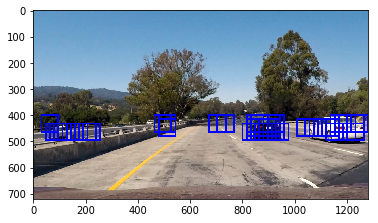

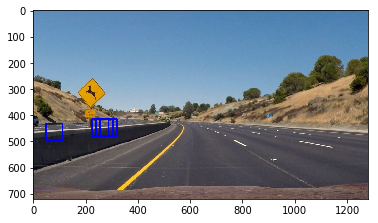

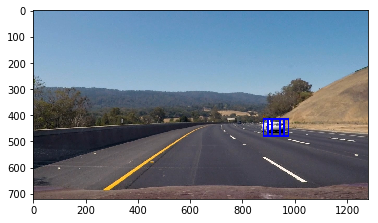

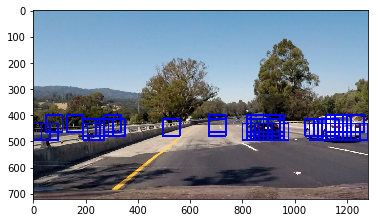

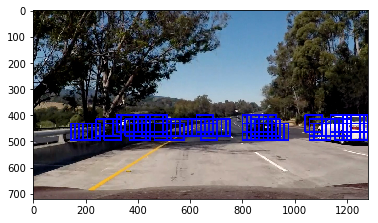

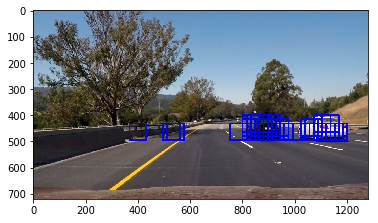

In [41]:
ystart = 400
ystop = 500
scale = 1

files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

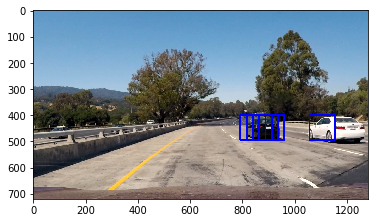

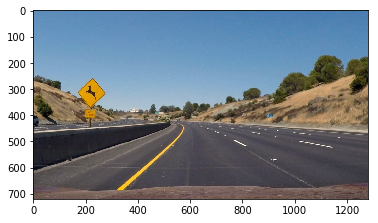

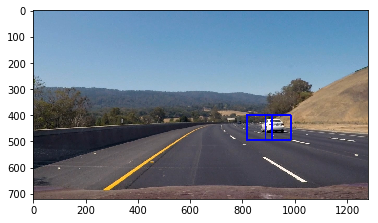

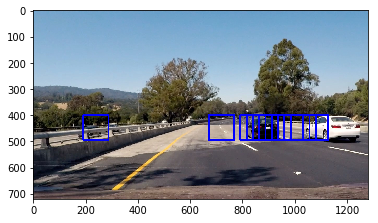

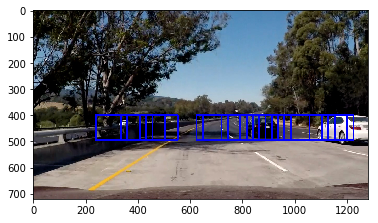

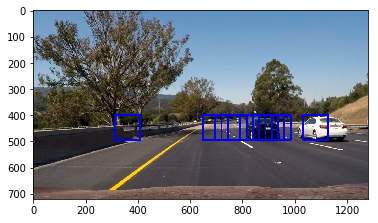

In [24]:
ystart = 400
ystop = 500
scale = 1.5

files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

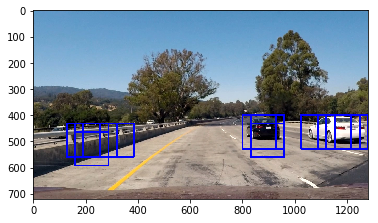

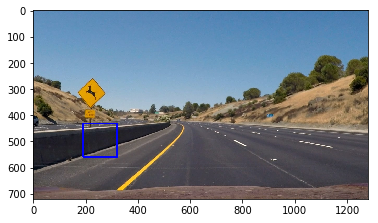

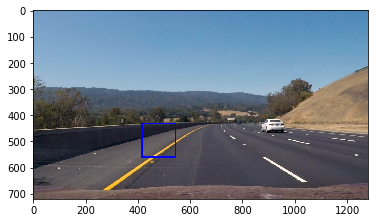

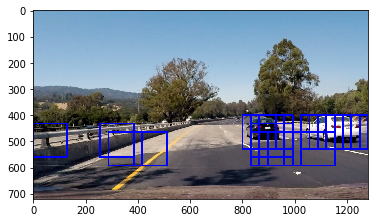

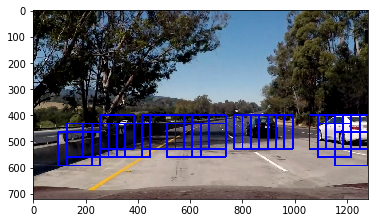

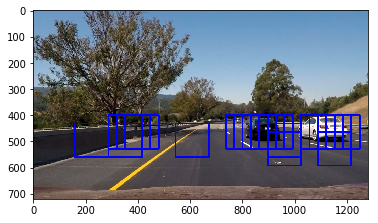

In [43]:
ystart = 400
ystop = 600
scale = 2

files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

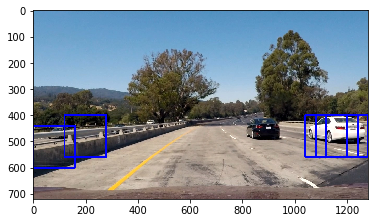

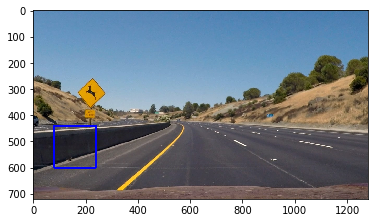

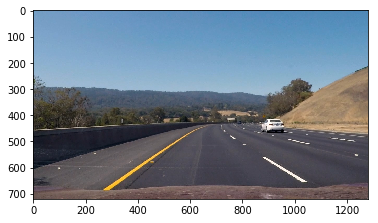

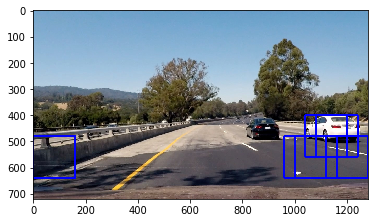

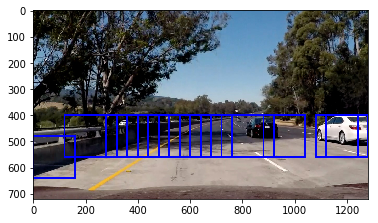

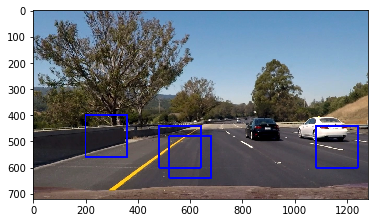

In [46]:
ystart = 400
ystop = 650
scale = 2.5

files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

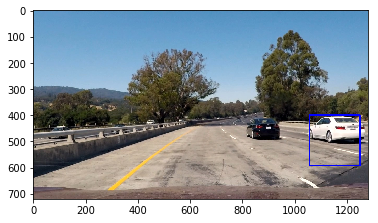

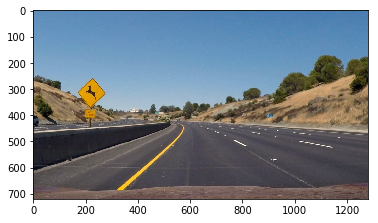

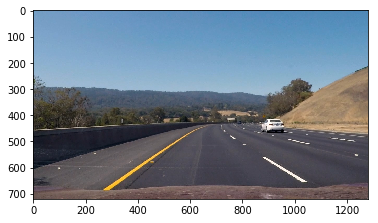

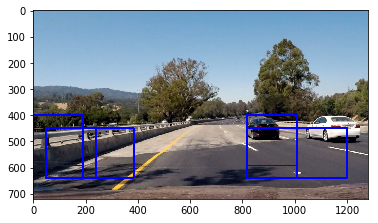

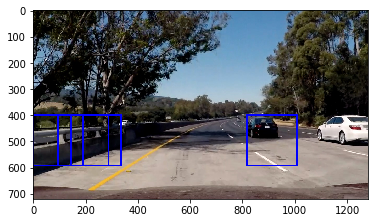

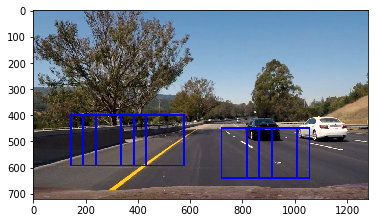

In [44]:
ystart = 400
ystop = 650
scale = 3

files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

## 4. Make all the process on picture

In [21]:
## function to produce heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [22]:
# Define a function that can extract features using sub-sampling and make predictions
def find_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    windows = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch[:,:,0].shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch[:,:,0].shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get features
            features = extract_features([subimg], color_space='HLS', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

            # Scale features and make a prediction
            test_features = X_scaler.transform(features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)]) 
                
    return windows

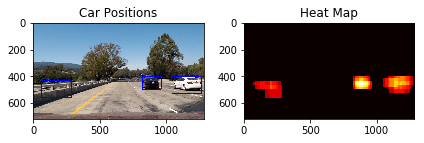

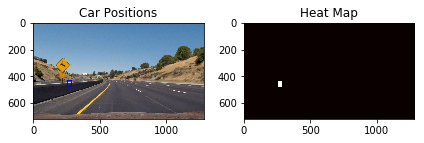

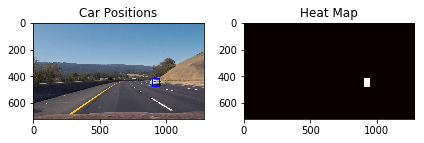

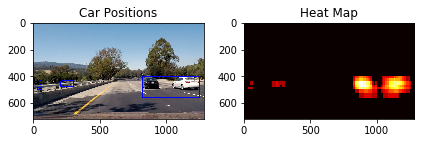

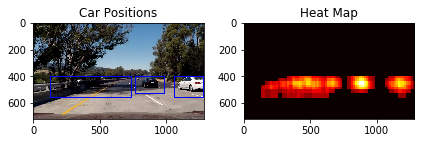

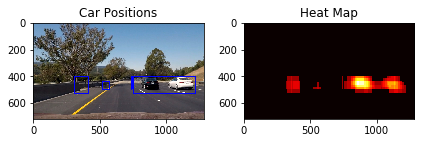

In [23]:
## print the windows on pictures
files = glob.glob('./test_images/test*.jpg')
for file in files:
    img = mpimg.imread(file)
    ystart = 400
    windows = []
    for scale, ystop in [(1,500), (1.5, 500), (2,600), (2.5,650)]:
        out_img = find_windows(img, ystart, ystop, scale, clf, X_scaler, orient, 
                               pix_per_cell, cell_per_block, spatial_size, hist_bins)
        windows.extend(out_img)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows)
    heat = apply_threshold(heat,3)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

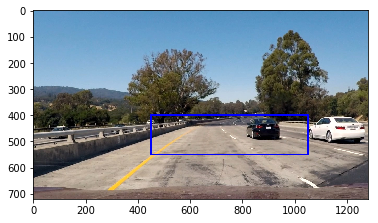

In [33]:
## define a function to filter the wrong windows which appear suddenly in the middle of the window
## middle of the window: krit_area - ((y_min, y_max), (x_min, x_max))

# first show the krit_area
krit_area = ((400, 550), (450, 1050))
image = mpimg.imread('./test_images/test1.jpg')
lefttop = (np.min(krit_area[1]),np.min(krit_area[0]))
rightdown = (np.max(krit_area[1]),np.max(krit_area[0]))
cv2.rectangle(image, lefttop, rightdown, (0,0,255), 6)
plt.imshow(image)

In [39]:
def filterout(old_labels, new_labels, krit_area = ((400, 600),(300, 900)), toler = 40):
    
    ignore_numbers = []
    
    for car_number in range(1, new_labels[1]+1):
        wrong = True # flage to determine wether the window is wrong
        # Find pixels with each car_number label value
        nonzero = (new_labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define the middel point of the new detected window
        middle_pointx = (np.max(nonzerox) + np.min(nonzerox))/2
        middle_pointy = (np.max(nonzeroy) + np.min(nonzeroy))/2
        
        if middle_pointx < np.max(krit_area[1]) and middle_pointx > np.min(krit_area[1]) and\
           middle_pointy < np.max(krit_area[0]) and middle_pointy > np.min(krit_area[0]):
                for old_car_number in range(1, old_labels[1]+1):
                    # Find pixels with each car_number label value
                    old_nonzero = (old_labels[0] == old_car_number).nonzero()
                    # Identify x and y values of those pixels
                    old_nonzeroy = np.array(old_nonzero[0])
                    old_nonzerox = np.array(old_nonzero[1])
                    # Define the middel point of the new detected window
                    old_middle_pointx = (np.max(old_nonzerox) + np.min(old_nonzerox))/2
                    old_middle_pointy = (np.max(old_nonzeroy) + np.min(old_nonzeroy))/2
                    if abs(middle_pointx - old_middle_pointx) < toler and abs(middle_pointy - old_middle_pointy) < toler:
                        wrong = False
        if wrong:
            for i in range(len(new_labels[0])):
                for j in range(len(new_labels[0][i])):
                    if new_labels[0][i][j] == car_number: new_labels[0][i][j] = 0
                    elif new_labels[0][i][j] > car_number: new_labels[0][i][j] -= 1
            new_labels[1] -= 1
        return new_labels

In [42]:
## define the function tp operate on videos

def find_video(image):
    
    global old_labels
    
    ## load the data
    clf = joblib.load("train_model.m")
    with open('data.pickle', 'rb') as file:
        data_dict = pickle.load(file)
        X_scaler = data_dict['X_scaler']

    ## set parameters
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    
    krit_area = ((400, 600),(300, 900))
    toler = 30
    ystart = 400
    windows = []
    for scale, ystop in [(1,500), (1.5, 500), (2,600), (2.5,650)]:
        out_img = find_windows(image, ystart, ystop, scale, clf, X_scaler, orient, 
                               pix_per_cell, cell_per_block, spatial_size, hist_bins)
        windows.extend(out_img)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows)
    heat = apply_threshold(heat,3)
    heatmap = np.clip(heat, 0, 255)
    
    labels = list(label(heatmap))
    if len(old_labels) > 0:
        labels = filterout(old_labels, labels, krit_area = krit_area, toler = toler)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    old_labels = labels
    
    return draw_img

## 5. Generate the videos

In [43]:
old_labels = []
myclip = VideoFileClip('project_video.mp4')
clip = myclip.fl_image(find_video)
%time clip.write_videofile('./output_videos/video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_videos/video.mp4
[MoviePy] Writing video ./output_videos/video.mp4



  5%|████▏                                                                         | 67/1261 [04:43<1:24:10,  4.23s/it]


 11%|████████▏                                                                    | 135/1261 [09:20<1:17:57,  4.15s/it]


 16%|████████████▍                                                                | 203/1261 [14:13<1:14:06,  4.20s/it]


 21%|████████████████▌                                                            | 271/1261 [19:23<1:10:49,  4.29s/it]


 27%|████████████████████▋                                                        | 339/1261 [24:23<1:06:21,  4.32s/it]


 32%|████████████████████████▊                                                    | 407/1261 [29:19<1:01:32,  4.32s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [34:17<56:43,  4.33s/it]


 43%|██████████████████████████████████                                             | 543/1261 [39:10<51:47,  4.33s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [44:19<47:09,  4.35s/it]


 50%|███████████████████████████████████████▊                                       | 636/1261 [46:11<45:23,  4.36s/it]


TypeError: 'NoneType' object is not subscriptable

In [44]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/video.mp4'))